In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import pickle as pkl
import os

import GCRCatalogs
from GCRCatalogs import GCRQuery
GCRCatalogs.set_root_dir("/data/scratch/dc2_nfs/")

We specify the path at which we'll save the pkl file:

In [2]:
file_name = "dc2_lensing_catalog_objectmatch.pkl"
file_path = os.path.join("/data", "scratch", "dc2local", file_name)
file_already_populated = os.path.isfile(file_path)

---

### Object-with-truth–match

We load in the object-with-truth-match catalog and list all available quantities:

In [3]:
object_truth_cat = GCRCatalogs.load_catalog('desc_dc2_run2.2i_dr6_object_with_truth_match')

In [4]:
object_truth_cat.list_all_quantities()

['magerr_i',
 'psf_fwhm_y',
 'cModelFlux_flag_r',
 'mag_u_truth',
 'psf_fwhm_u',
 'IxxPSF_pixel_y',
 'magerr_i_cModel',
 'mag_g_truth',
 'yErr',
 'blendedness',
 'is_good_match',
 'Iyy_pixel_i',
 'Iyy_pixel_u',
 'cModelFlux_flag_u',
 'is_nearest_neighbor',
 'IyyPSF_pixel_i',
 'mag_r',
 'Ixy_pixel_u',
 'snr_i_cModel',
 'IxyPSF_pixel_z',
 'mag_i_cModel',
 'flux_g_truth',
 'Ixy_pixel_y',
 'IxxPSF_pixel_z',
 'y',
 'dec_truth',
 'Ixx_pixel_g',
 'mag_y',
 'patch_truth',
 'rv_truth',
 'I_flag_z',
 'Ixy_pixel_g',
 'parentObjectId',
 'Iyy_pixel',
 'Ixx_pixel_i',
 'cModelFlux_i',
 'cModelFlux_flag_z',
 'clean',
 'mag_i',
 'magerr_g',
 'magerr_y',
 'cModelFluxErr_r',
 'cosmodc2_hp_truth',
 'snr_u_cModel',
 'av_truth',
 'mag_u',
 'magerr_u_cModel',
 'id_string_truth',
 'magerr_z_cModel',
 'cModelFlux_flag_i',
 'flux_z_truth',
 'flux_y_truth',
 'match_sep',
 'cModelFluxErr_u',
 'x',
 'cModelFluxErr_y',
 'mag_y_cModel',
 'IxyPSF_pixel_r',
 'mag_z',
 'psNdata',
 'psFlux_flag_r',
 'psFlux_u',
 'snr_y_

And we fetch the variables we want:

In [5]:
object_truth_df = object_truth_cat.get_quantities(
    quantities = ["cosmodc2_id_truth", "id_truth", "objectId", "match_objectId",
                  "truth_type", "ra_truth", "dec_truth", "redshift_truth",
                  "flux_u_truth", "flux_g_truth", "flux_r_truth", "flux_i_truth", "flux_z_truth", "flux_y_truth",
                  "mag_u_truth", "mag_g_truth", "mag_r_truth", "mag_i_truth", "mag_z_truth", "mag_y_truth",
                  "Ixx_pixel", "Iyy_pixel", "Ixy_pixel",
                  "IxxPSF_pixel_u", "IxxPSF_pixel_g", "IxxPSF_pixel_r", "IxxPSF_pixel_i", "IxxPSF_pixel_z", "IxxPSF_pixel_y", 
                  "IyyPSF_pixel_u", "IyyPSF_pixel_g", "IyyPSF_pixel_r", "IyyPSF_pixel_i", "IyyPSF_pixel_z", "IyyPSF_pixel_y",
                  "IxyPSF_pixel_u", "IxyPSF_pixel_g", "IxyPSF_pixel_r", "IxyPSF_pixel_i", "IxyPSF_pixel_z", "IxyPSF_pixel_y",
                  "psf_fwhm_u", "psf_fwhm_g", "psf_fwhm_r", "psf_fwhm_i", "psf_fwhm_z", "psf_fwhm_y"]
)

object_truth_df = pd.DataFrame(object_truth_df)

We create an ra/dec filter that we'll apply to CosmoDC2, as well as an equivalent (but faster) healpix filter:

In [6]:
max_ra = np.nanmax(object_truth_df['ra_truth'])
min_ra = np.nanmin(object_truth_df['ra_truth'])
max_dec = np.nanmax(object_truth_df['dec_truth'])
min_dec = np.nanmin(object_truth_df['dec_truth'])
ra_dec_filters = [f'ra >= {min_ra}', f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

In [7]:
vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

We see that there are around 11.1 million objects in the object-truth table:

In [8]:
object_truth_df.shape

(11116206, 47)

But a small portion of these objects are stars or supernovae rather than galaxies, so we filter them out:

In [9]:
object_truth_df = object_truth_df[object_truth_df['truth_type'] == 1]

In [10]:
object_truth_df.shape

(10874345, 47)

There are also a few duplicate `cosmodc2_id`s. These arise because a small number of measured objects in `object_truth_df` are matched with the same `cosmodc2_id` in the truth table. But the only columns of `object_truth_df` that we are using are the `_truth` columns, so our merged data frame has the same truth values listed multiple times (as opposed to slighly different measured values corresponding to the multiple objects that were matched to the same `cosmodc2_id`).

In [11]:
object_truth_df.drop_duplicates(subset = ['cosmodc2_id_truth'], inplace = True)

In [12]:
object_truth_df.shape

(10811028, 47)

Here are the different ID variables in the object-truth table:

In [13]:
object_truth_df[['cosmodc2_id_truth', 'id_truth', 'objectId', 'match_objectId']]

,cosmodc2_id_truth,id_truth,objectId,match_objectId
0,8757401501,8757401501,15982501021353368,15982501021353368
1,8750694182,8750694182,15982501021353393,15982501021353393
2,8752812073,8752812073,15982501021353397,15982501021353397
3,8750045581,8750045581,15982501021353414,15982501021353414
4,8751841300,8751841300,15982501021353419,15982501021353419
...,...,...,...,...
11116200,5945279520,5945279520,17711783703784921,17711783703784921
11116201,5941110663,5941110663,17711783703784922,17711783703784922
11116203,5952753448,5952753448,17711783703784924,17711783703784924
11116204,5939749788,5939749788,17711783703784925,17711783703784925


We see that `id` and `cosmodc2_id` are equivalent, at least for galaxies:

In [14]:
(object_truth_df['cosmodc2_id_truth'] == object_truth_df['id_truth']).mean()

1.0

And same goes for `objectId` and `match_objectId`:

In [15]:
(object_truth_df['objectId'] == object_truth_df['match_objectId']).mean()

1.0

Here's the distribution of magnitude in each band:

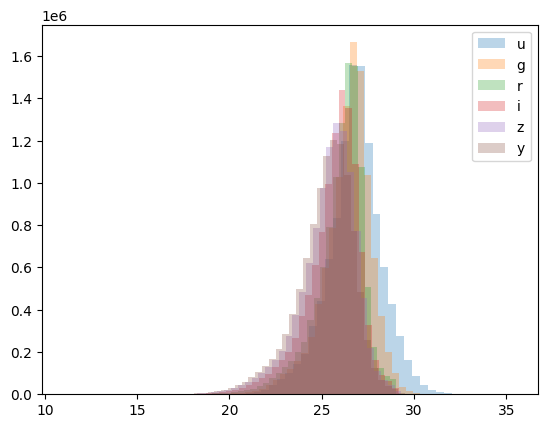

In [16]:
_ = plt.hist(object_truth_df['mag_u_truth'], bins = 50, alpha = 0.3, label = 'u')
_ = plt.hist(object_truth_df['mag_g_truth'], bins = 50, alpha = 0.3, label = 'g')
_ = plt.hist(object_truth_df['mag_r_truth'], bins = 50, alpha = 0.3, label = 'r')
_ = plt.hist(object_truth_df['mag_i_truth'], bins = 50, alpha = 0.3, label = 'i')
_ = plt.hist(object_truth_df['mag_z_truth'], bins = 50, alpha = 0.3, label = 'z')
_ = plt.hist(object_truth_df['mag_y_truth'], bins = 50, alpha = 0.3, label = 'y')
_ = plt.legend()

And here's the distribution of redshift:

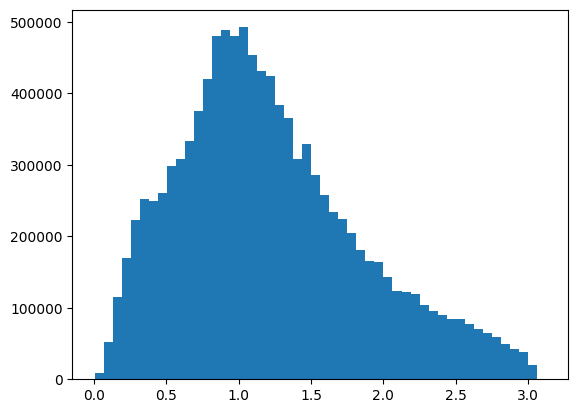

In [17]:
_ = plt.hist(object_truth_df['redshift_truth'], bins = 50)

---

### CosmoDC2

Next, we load in CosmoDC2 and list all available quantities:

In [18]:
config_overwrite = dict(
    catalog_root_dir='/data/scratch/dc2_nfs/cosmoDC2'
)

cosmo_cat = GCRCatalogs.load_catalog('desc_cosmodc2', config_overwrite)

In [19]:
cosmo_cat.list_all_quantities()

['mag_true_z_lsst_no_host_extinction',
 'sed_11467_1710_bulge',
 'stellar_mass_disk',
 'ellipticity_1_bulge_true',
 'ellipticity_2_true',
 'mag_r_sdss',
 'sed_2998_186_bulge',
 'sed_6548_406_bulge_no_host_extinction',
 'shear_2_phosim',
 'sed_1246_306_bulge',
 'mag_i_lsst',
 'sed_4848_300_bulge_no_host_extinction',
 'sed_1000_246',
 'mag_r',
 'Mag_true_r_sdss_z0',
 'sed_4048_251_no_host_extinction',
 'sed_8846_549_no_host_extinction',
 'sed_6166_382_no_host_extinction',
 'sed_9978_1489_bulge',
 'mag_y',
 'sed_8329_517_bulge_no_host_extinction',
 'sed_4565_283_disk',
 'sed_3184_197_disk',
 'mag_true_i_lsst',
 'sed_2998_186_disk',
 'sed_17402_2596_no_host_extinction',
 'Mag_true_u_sdss_z0_no_host_extinction',
 'Mag_true_r_lsst_z0',
 'sed_5806_360_bulge_no_host_extinction',
 'halo_id',
 'Mag_true_Y_lsst_z0',
 'sed_8846_549_disk_no_host_extinction',
 'mag_true_z_lsst',
 'ellipticity_2_disk_true_dc2',
 'mag_r_lsst',
 'mag_i',
 'mag_true_y',
 'sed_6548_406_disk',
 'sed_5148_319_bulge_no_host

And we fetch the variables we want.

Some notes:
- We only pull objects in the ra/dec region from the object-with-truth-match table, using the filters defined above.
- ellipticity_1_true and ellipticity_2_true are the unlensed ellipticities. Ideally we'd want the lensed versions ellipticity_1 and ellipticity_2, which are listed [here](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md) but are not available (see the above list). There's also ellipticity_1_true_dc2 and ellipticity_2_true_dc2, but those are deprecated.

In [20]:
cosmo_df = cosmo_cat.get_quantities(
    quantities = ["galaxy_id", "ra", "dec",
                  "ellipticity_1_true", "ellipticity_2_true",
                  "shear_1", "shear_2", "convergence"],
    filters = ra_dec_filters,
    native_filters = healpix_filter
)
cosmo_df = pd.DataFrame(cosmo_df)

We see that there are around 128 million galaxies in CosmoDC2:

In [21]:
cosmo_df.shape

(128290189, 8)

Here's the ID variable in CosmoDC2. It has the same format as `cosmodc2_id_truth` in the object-with-truth-match table:

In [22]:
cosmo_df['galaxy_id']

0            4937506723
1            4937521584
2            4937533577
3            4937618301
4            4937638954
                ...    
128290184    8833313718
128290185    8833313719
128290186    8833313723
128290187    8833313726
128290188    8833313727
Name: galaxy_id, Length: 128290189, dtype: int64

---

### Merge `object_truth_df` and `cosmo_df`

Now we merge the object-with-truth-match table with CosmoDC2 using the galaxies' CosmoDC2 IDs (`galaxy_id` in `cosmo_df` and `cosmodc2_id_truth` in `object_truth_df`).

In [23]:
merge_df = object_truth_df.merge(
    cosmo_df, 
    left_on = "cosmodc2_id_truth",
    right_on = "galaxy_id", 
    how = "left" 
)

As expected, the new data frame has the same number of rows as `object_truth_df`:

In [24]:
merge_df.shape

(10811028, 55)

But we find that there are around 750,000 galaxies in `object_truth_df` that are not in `cosmo_df`:

In [25]:
print(merge_df['galaxy_id'].isna().sum())
print(merge_df['galaxy_id'].isna().mean())

741102
0.06855055781929341


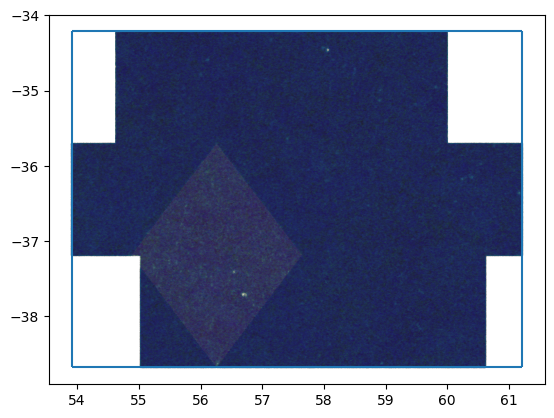

In [26]:
_ = plt.scatter(merge_df['ra_truth'][~merge_df['galaxy_id'].isna()],
                merge_df['dec_truth'][~merge_df['galaxy_id'].isna()],
                c = merge_df['redshift_truth'][~merge_df['galaxy_id'].isna()], alpha = 0.005, s = 1)
_ = plt.vlines(x = [min_ra, max_ra], ymin = max_dec, ymax = min_dec)
_ = plt.hlines(y = [min_dec, max_dec], xmin = min_ra, xmax = max_ra)

It appears that this small number of galaxies is missing from a portion of the sky in CosmoDC2. We've confirmed that this is an inherent problem in CosmoDC2 itself and is not related to our merging strategy. The other BLISS projects that work with DC2 have encountered the same problem.

We filter these galaxies out since they do not have shear, convergence, or ellipticity (and thus are not useful for our purposes):

In [27]:
merge_df = merge_df[~merge_df['galaxy_id'].isna()]

We confirm that the distribution of per-band magnitude and the distribution of redshift are essentially the same as before:

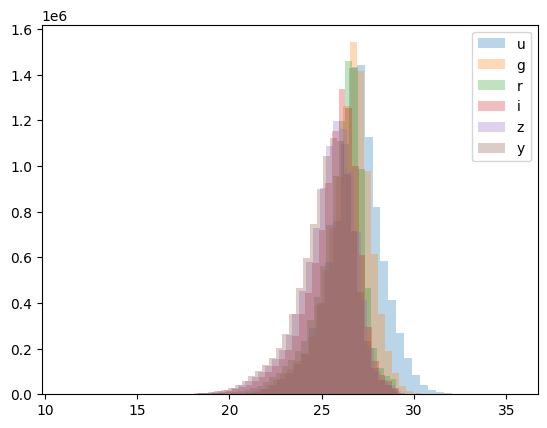

In [28]:
_ = plt.hist(merge_df['mag_u_truth'], bins = 50, alpha = 0.3, label = 'u')
_ = plt.hist(merge_df['mag_g_truth'], bins = 50, alpha = 0.3, label = 'g')
_ = plt.hist(merge_df['mag_r_truth'], bins = 50, alpha = 0.3, label = 'r')
_ = plt.hist(merge_df['mag_i_truth'], bins = 50, alpha = 0.3, label = 'i')
_ = plt.hist(merge_df['mag_z_truth'], bins = 50, alpha = 0.3, label = 'z')
_ = plt.hist(merge_df['mag_y_truth'], bins = 50, alpha = 0.3, label = 'y')
_ = plt.legend()

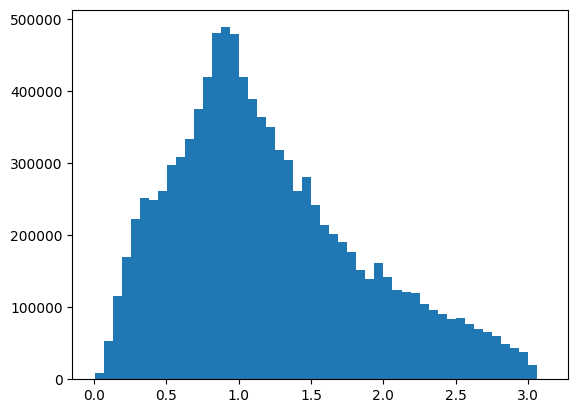

In [29]:
_ = plt.hist(merge_df['redshift_truth'], bins = 50)

And now we can examine shear and convergence, which were initially in `cosmo_df`:

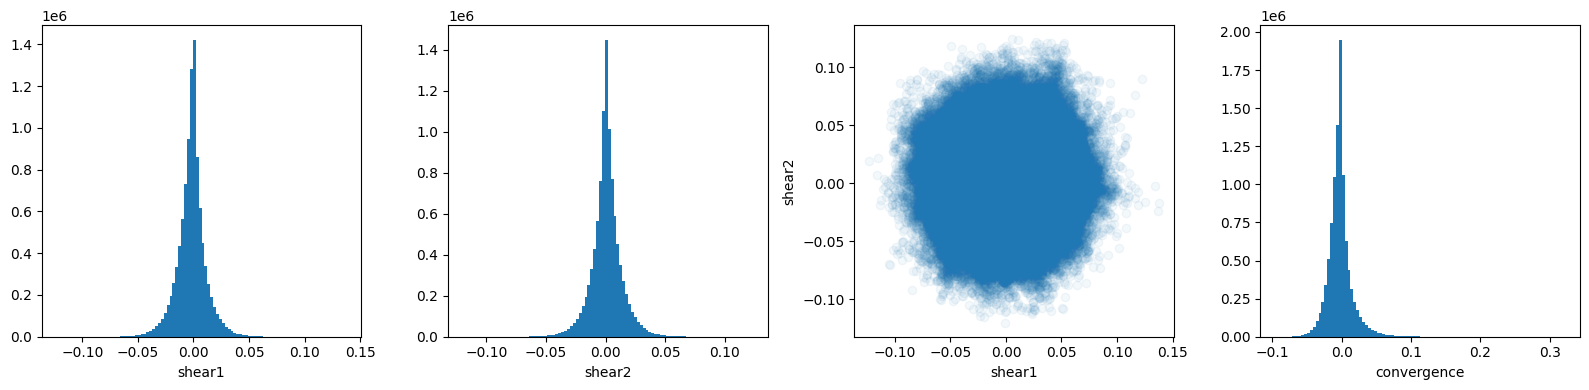

In [30]:
fig, ax = plt.subplots(1, 4, figsize = (16,4))
_ = ax[0].hist(merge_df['shear_1'], bins = 100)
_ = ax[0].set_xlabel('shear1')
_ = ax[1].hist(merge_df['shear_2'], bins = 100)
_ = ax[1].set_xlabel('shear2')
_ = ax[2].scatter(merge_df['shear_1'], merge_df['shear_2'], alpha = 0.05)
_ = ax[2].set_xlabel('shear1')
_ = ax[2].set_ylabel('shear2')
_ = ax[3].hist(merge_df['convergence'], bins = 100)
_ = ax[3].set_xlabel('convergence')
fig.tight_layout()

We remove `ra_truth` and `dec_truth` since they're the same as `ra` and `dec`, respectively:

In [31]:
merge_df.drop(columns = ['ra_truth', 'dec_truth'], inplace = True)

And finally, we remove the `_truth` suffix from the mag, flux, and redshift variables:

In [32]:
merge_df.rename(columns = {
    "redshift_truth": "redshift",
    "flux_u_truth": "flux_u",
    "flux_g_truth": "flux_g",
    "flux_r_truth": "flux_r",
    "flux_i_truth": "flux_i",
    "flux_z_truth": "flux_z",
    "flux_y_truth": "flux_y",
    "mag_u_truth": "mag_u",
    "mag_g_truth": "mag_g",
    "mag_r_truth": "mag_r",
    "mag_i_truth": "mag_i",
    "mag_z_truth": "mag_z",
    "mag_y_truth": "mag_y",
}, inplace = True)

---

Finally, we save `merge_df` to `file_path`:

In [33]:
with open(file_path, "wb") as f:
    pkl.dump(merge_df, f)